In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")



<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Read and review data</h3>
</div>

The data is a single column timstamp, with timestamps extending from 1/1/1970 to 4/18/1970


In [2]:
import json

logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df.dtypes

login_time    datetime64[ns]
dtype: object

login timestamps range from 1/1/1970 to 4/13/1970

In [4]:
logins_df.agg(
    min_time_stamp=('login_time', 'min'),
    max_time_stamp=('login_time', 'max'),
).reset_index()

,index,login_time
0,min_time_stamp,1970-01-01 20:12:16
1,max_time_stamp,1970-04-13 18:57:38


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Augment the data</h3>
</div>


1. add a <font color=purple>minutes_since_start</font> column containing minutes since 1/1/1970 to each row
2. add a <font color=purple>15_minute_intervals</font> column by dividing the minutes_since_start by 15
3. add a <font color=purple>15_minute_timestamps</font> column reconverting the 15 minute itervals back to a timestamp
4. add a few day of week, simple date and other columns in case there are day-level fluctuations in the data

Then let's just poke around and see what we can see

In [5]:

# Convert the 'login_time' column to datetime format
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

# Find the minimum timestamp
min_timestamp = logins_df['login_time'].min()

# Calculate the minutes since the minimum timestamp
logins_df['minutes_since_start'] = (logins_df['login_time'] - min_timestamp).dt.total_seconds() / 60

# Calculate 15-minute intervals
logins_df['15_minute_intervals'] = logins_df['minutes_since_start'] // 15
logins_df['15_minute_timestamps'] = min_timestamp + pd.to_timedelta(logins_df['15_minute_intervals'] * 15, unit='minutes')

logins_df['login_day'] = pd.to_datetime(logins_df['login_time'], unit='ns').dt.date
logins_df['login_dow'] = logins_df['login_time'].dt.day_name()
logins_df['hour'] = logins_df['login_time'].dt.hour
logins_df.loc[ logins_df['login_dow'].isin(['Saturday', 'Sunday']), 'week_phase' ] = 'weekend'
logins_df.loc[ ~logins_df['login_dow'].isin(['Saturday', 'Sunday']), 'week_phase' ] = 'weekday'
# Now we have what we need



---
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Look at the 15 minute aggregations</h3>
</div>

### look at the 15 minute intervals overall

It looks like there are some cycles going on, but I think we need to zoom in to see what they are

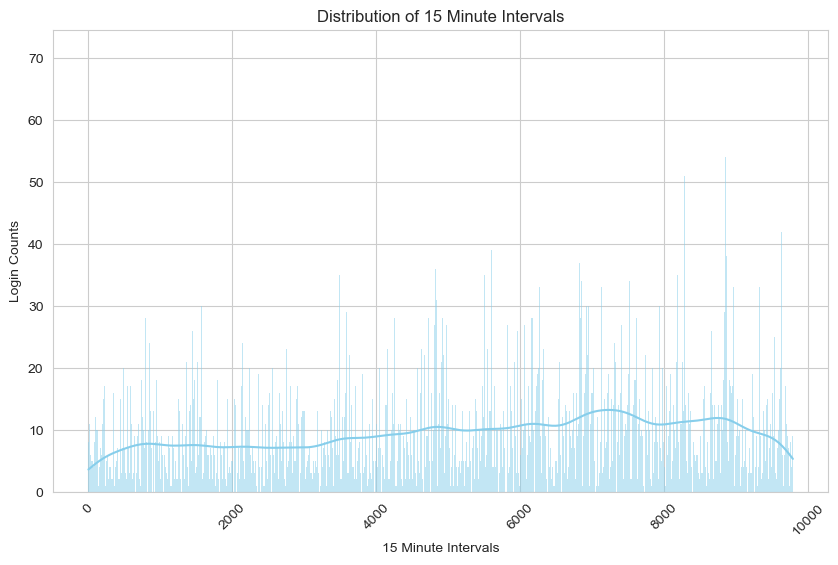

In [6]:
# Create a Seaborn histogram
sns.set_style('whitegrid')  # Set the plot style

plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(data=logins_df, x='15_minute_intervals', bins=range(int(logins_df['15_minute_intervals'].max()) + 2), kde=True, color='skyblue')

# Add labels and title
plt.xlabel('15 Minute Intervals')
plt.ylabel('Login Counts')
plt.title('Distribution of 15 Minute Intervals')
plt.xticks(rotation=45)

plt.show()

With fewer bins, we still see the cycles more clearly but still not able to characterize them

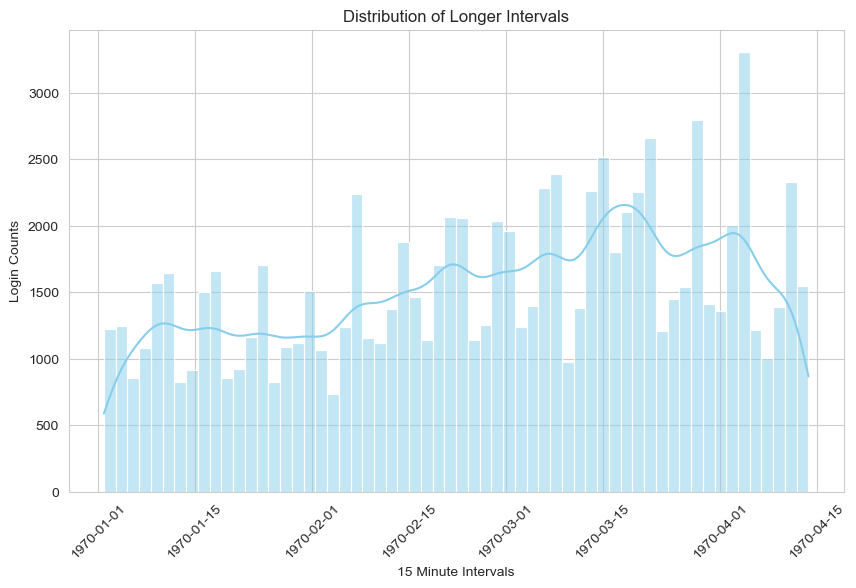

In [7]:
# Create a Seaborn histogram
sns.set_style('whitegrid')  # Set the plot style

plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(data=logins_df, x='15_minute_timestamps', bins=60, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('15 Minute Intervals')
plt.ylabel('Login Counts')
plt.title('Distribution of Longer Intervals')
plt.xticks(rotation=45)

plt.show()

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Hypothesis - there are daily cycles </h3>
</div>


There are consistent spikes and lulls in activity 

- Weekdays have similar lulls as weekdays, but the spikes are a little different
- Weekdays have a significant 11am spike, and 
- Weekends have a significant early morning spike



#### First, create a function to display one day at a time

In [8]:
def chart_date(logins_df, test_day, ax):

    # Filter data for the specific day
    day_data = logins_df[logins_df['login_day'] == test_day]
    if day_data.empty:
        print(f"No data available for {test_day}")
        return

    # Determine an appropriate number of bins
    bin_width = 15  # minutes per bin
    min_timestamp = day_data['15_minute_timestamps'].min()
    max_timestamp = day_data['15_minute_timestamps'].max()
    range_in_seconds = (max_timestamp - min_timestamp).total_seconds()
    num_bins = int(range_in_seconds / (bin_width * 60)) + 1
    sns.histplot(data=day_data, x='15_minute_timestamps', bins=num_bins, kde=True, color='skyblue', ax=ax)



#### Next, set up a grid, iterate though the date range, and call the chart_date function for one day at a time

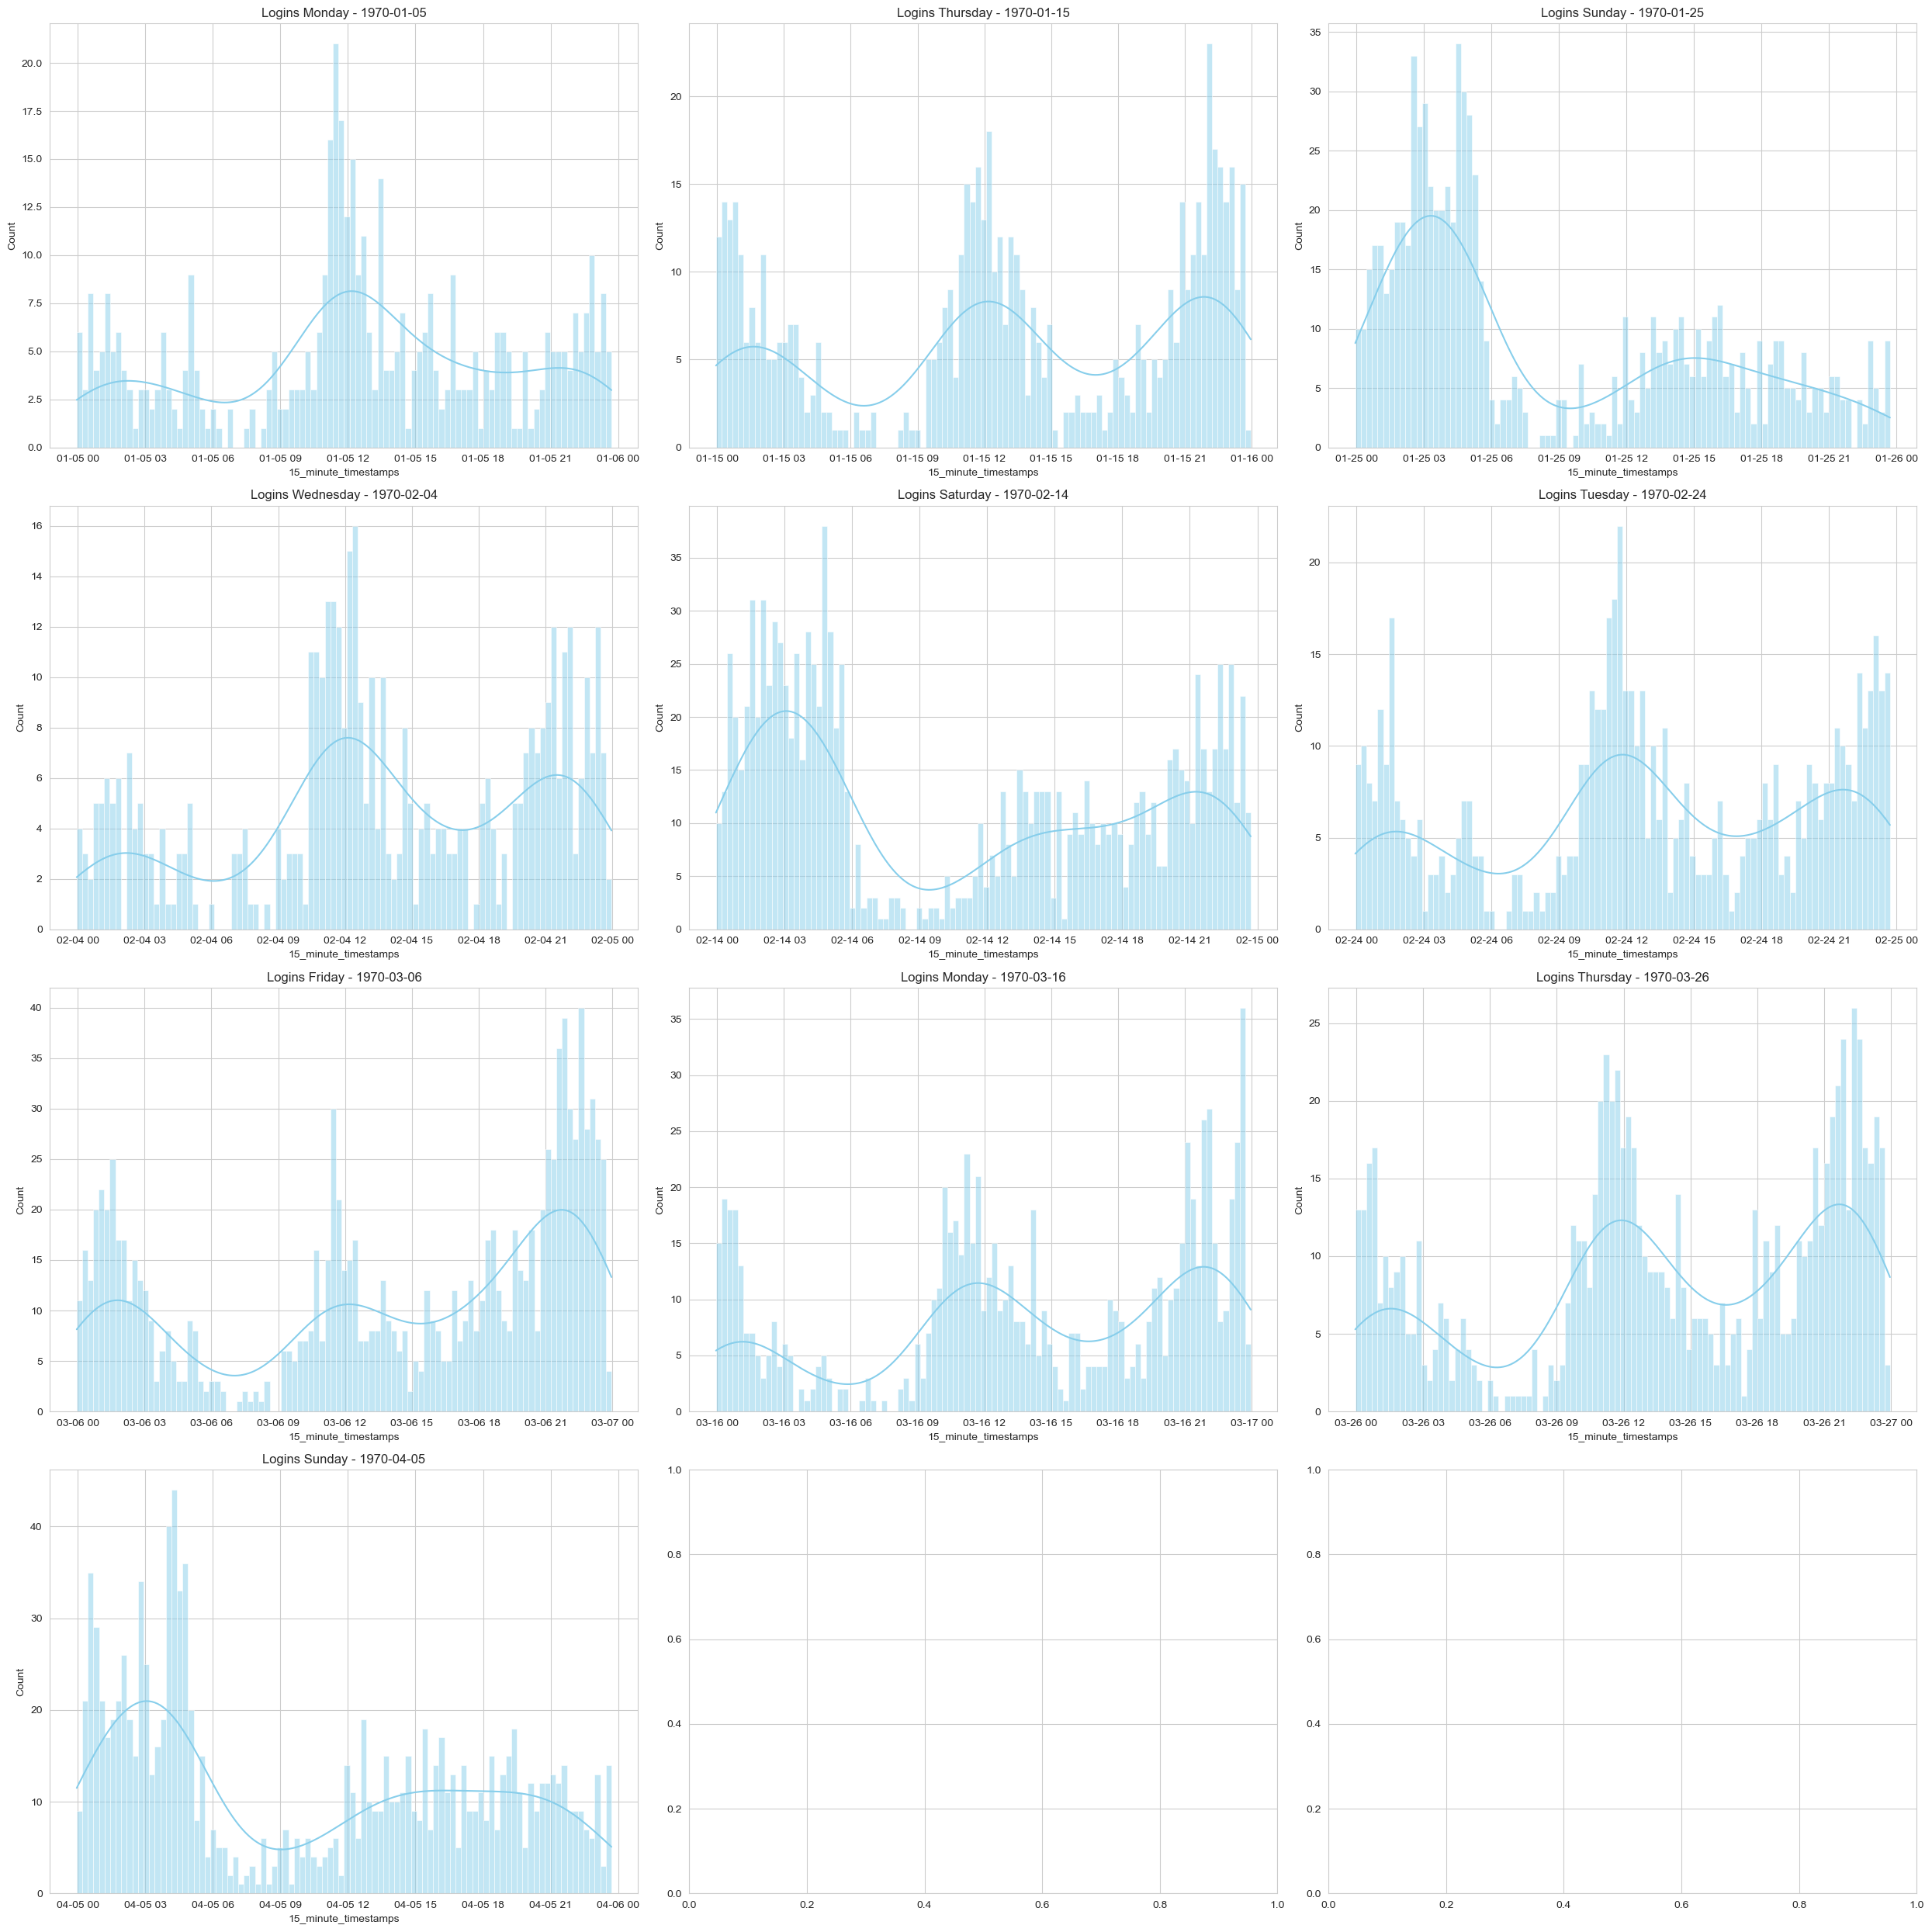

In [9]:
from datetime import datetime, timedelta

# Setup
sns.set_style('whitegrid')
start_date = pd.to_datetime('1970-01-05')
end_date = pd.to_datetime('1970-04-12')

# grid
num_rows = 4
num_columns = 3
days_to_stagger = 10

# Calculate the number of weeks to display
num_weeks = (end_date - start_date).days // 7 + 1  # Add 1 to include the start_date

figure, axis = plt.subplots(num_rows, num_columns, figsize=(25, 25))
row = 0
col = 0

while start_date <= end_date:
    if col >= num_columns:
        col = 0
        row += 1

    ax = axis[row, col]
    chart_date(logins_df, start_date, ax)
    date_string = start_date.strftime("%Y-%m-%d")
    ax.set_title(f"Logins {start_date.strftime('%A')} - {date_string}")

    start_date += timedelta(days=days_to_stagger)  # Move to the next day
    col += 1

plt.tight_layout()
plt.show()


#### Let's look at the average count per hour over the whole dataset

Weekdays have similar lulls as weekdays, but the spikes are a little different, with wekdays having a significant 11am spike, and weekends having a significant early morning spike.

In [10]:
def plot_hist(phase, color):
    sns.set_style('whitegrid')  # Set the plot style
    
    plt.figure(figsize=(10, 6))  # Set the figure size
    sns.histplot(data=logins_df[logins_df['week_phase']==phase], x='hour', bins=60, kde=True, color=color)
    # Add labels and title
    plt.xlabel('Hour')
    plt.ylabel('Login Counts')
    plt.title(f'Global total of {phase} logins across 24 hours')
    plt.xticks(rotation=45)
    plt.show()


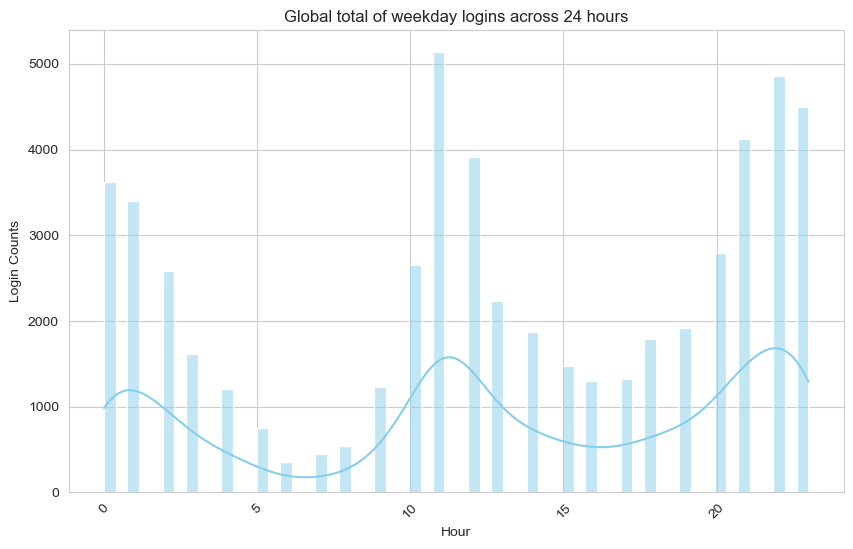

In [11]:
plot_hist('weekday', 'skyblue')

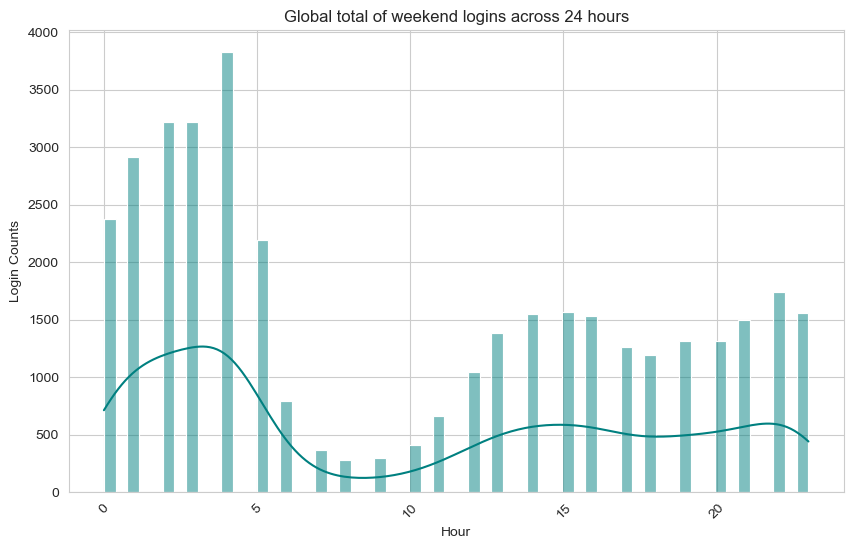

In [12]:
plot_hist('weekend', 'teal')


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Hypothesis - the cycle extend across all weeks</h3>
</div>

With some small variations, a birds eye view of all the weeks in the dataset do seem to support our original assumptions about spikes and lulls





---

#### heatmaps
The charts above give us a sense of some usage patterns, especially for any given single day, but we need to verify that the entire population supports those hypotheses

Segment the data into weeks, and view each our in each week as a heatmap
This should let us see the entire dataset and verify our assumptions

In [13]:
import pandas as pd

# Calculate the total login count for each day
daily_counts = logins_df.groupby('login_day').size()

# Group by date and hour, then calculate hourly counts
hourly_counts = logins_df.groupby(['login_day', 'hour']).size().unstack(fill_value=0)

# Calculate the percentage of logins for each hour
hourly_percentages = hourly_counts.divide(daily_counts, axis=0) * 100

# Create a separate DataFrame with date, hour, daily count, hourly count, and hourly percentage
result_df = pd.DataFrame(columns=['date', 'hour', 'daily_count', 'hourly_count', 'hourly_percentage'])

for date, daily_count in daily_counts.items():
    hourly_percentage = hourly_percentages.loc[date]
    hourly_count = hourly_counts.loc[date]
    for hour, percentage in hourly_percentage.items():
        count = hourly_count.get(hour, 0)
        result_df = result_df.append({'date': date, 'hour': hour, 'daily_count': daily_count, 'hourly_count': count, 'hourly_percentage': percentage}, ignore_index=True)

result_df['hour'] = result_df['hour'].astype(float)
result_df['daily_count'] = result_df['daily_count'].astype(float)
result_df['hourly_count'] = result_df['hourly_count'].astype(float)
result_df['dow'] = pd.to_datetime(result_df['date']).dt.day_name()
result_df.head(25)

,date,hour,daily_count,hourly_count,hourly_percentage,dow
0,1970-01-01,0.0,112.0,0.0,0.000000,Thursday
1,1970-01-01,1.0,112.0,0.0,0.000000,Thursday
2,1970-01-01,2.0,112.0,0.0,0.000000,Thursday
3,1970-01-01,3.0,112.0,0.0,0.000000,Thursday
4,1970-01-01,4.0,112.0,0.0,0.000000,Thursday
5,1970-01-01,5.0,112.0,0.0,0.000000,Thursday
6,1970-01-01,6.0,112.0,0.0,0.000000,Thursday
7,1970-01-01,7.0,112.0,0.0,0.000000,Thursday
8,1970-01-01,8.0,112.0,0.0,0.000000,Thursday
9,1970-01-01,9.0,112.0,0.0,0.000000,Thursday


In [14]:
def create_weekly_heatmap(start_date, ax):
    # Calculate the end date (one week later)
    end_date = start_date + pd.DateOffset(days=6)
    start_dow = start_date.strftime('%A')  # Extract the day of the week
    end_dow = end_date.strftime('%A')  # Extract the day of the week

    # Filter data for the specified week
    weekly_data = result_df[(result_df['date'] >= start_date) & (result_df['date'] <= end_date)]

    # Pivot the DataFrame for the heatmap
    heatmap_data = weekly_data.pivot('hour', 'date', 'hourly_count')

    # Create and display the heatmap
    sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Percentage of Total Logins'}, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis tick labels by 45 degrees
    # Other customization code (e.g., title, labels) can go here



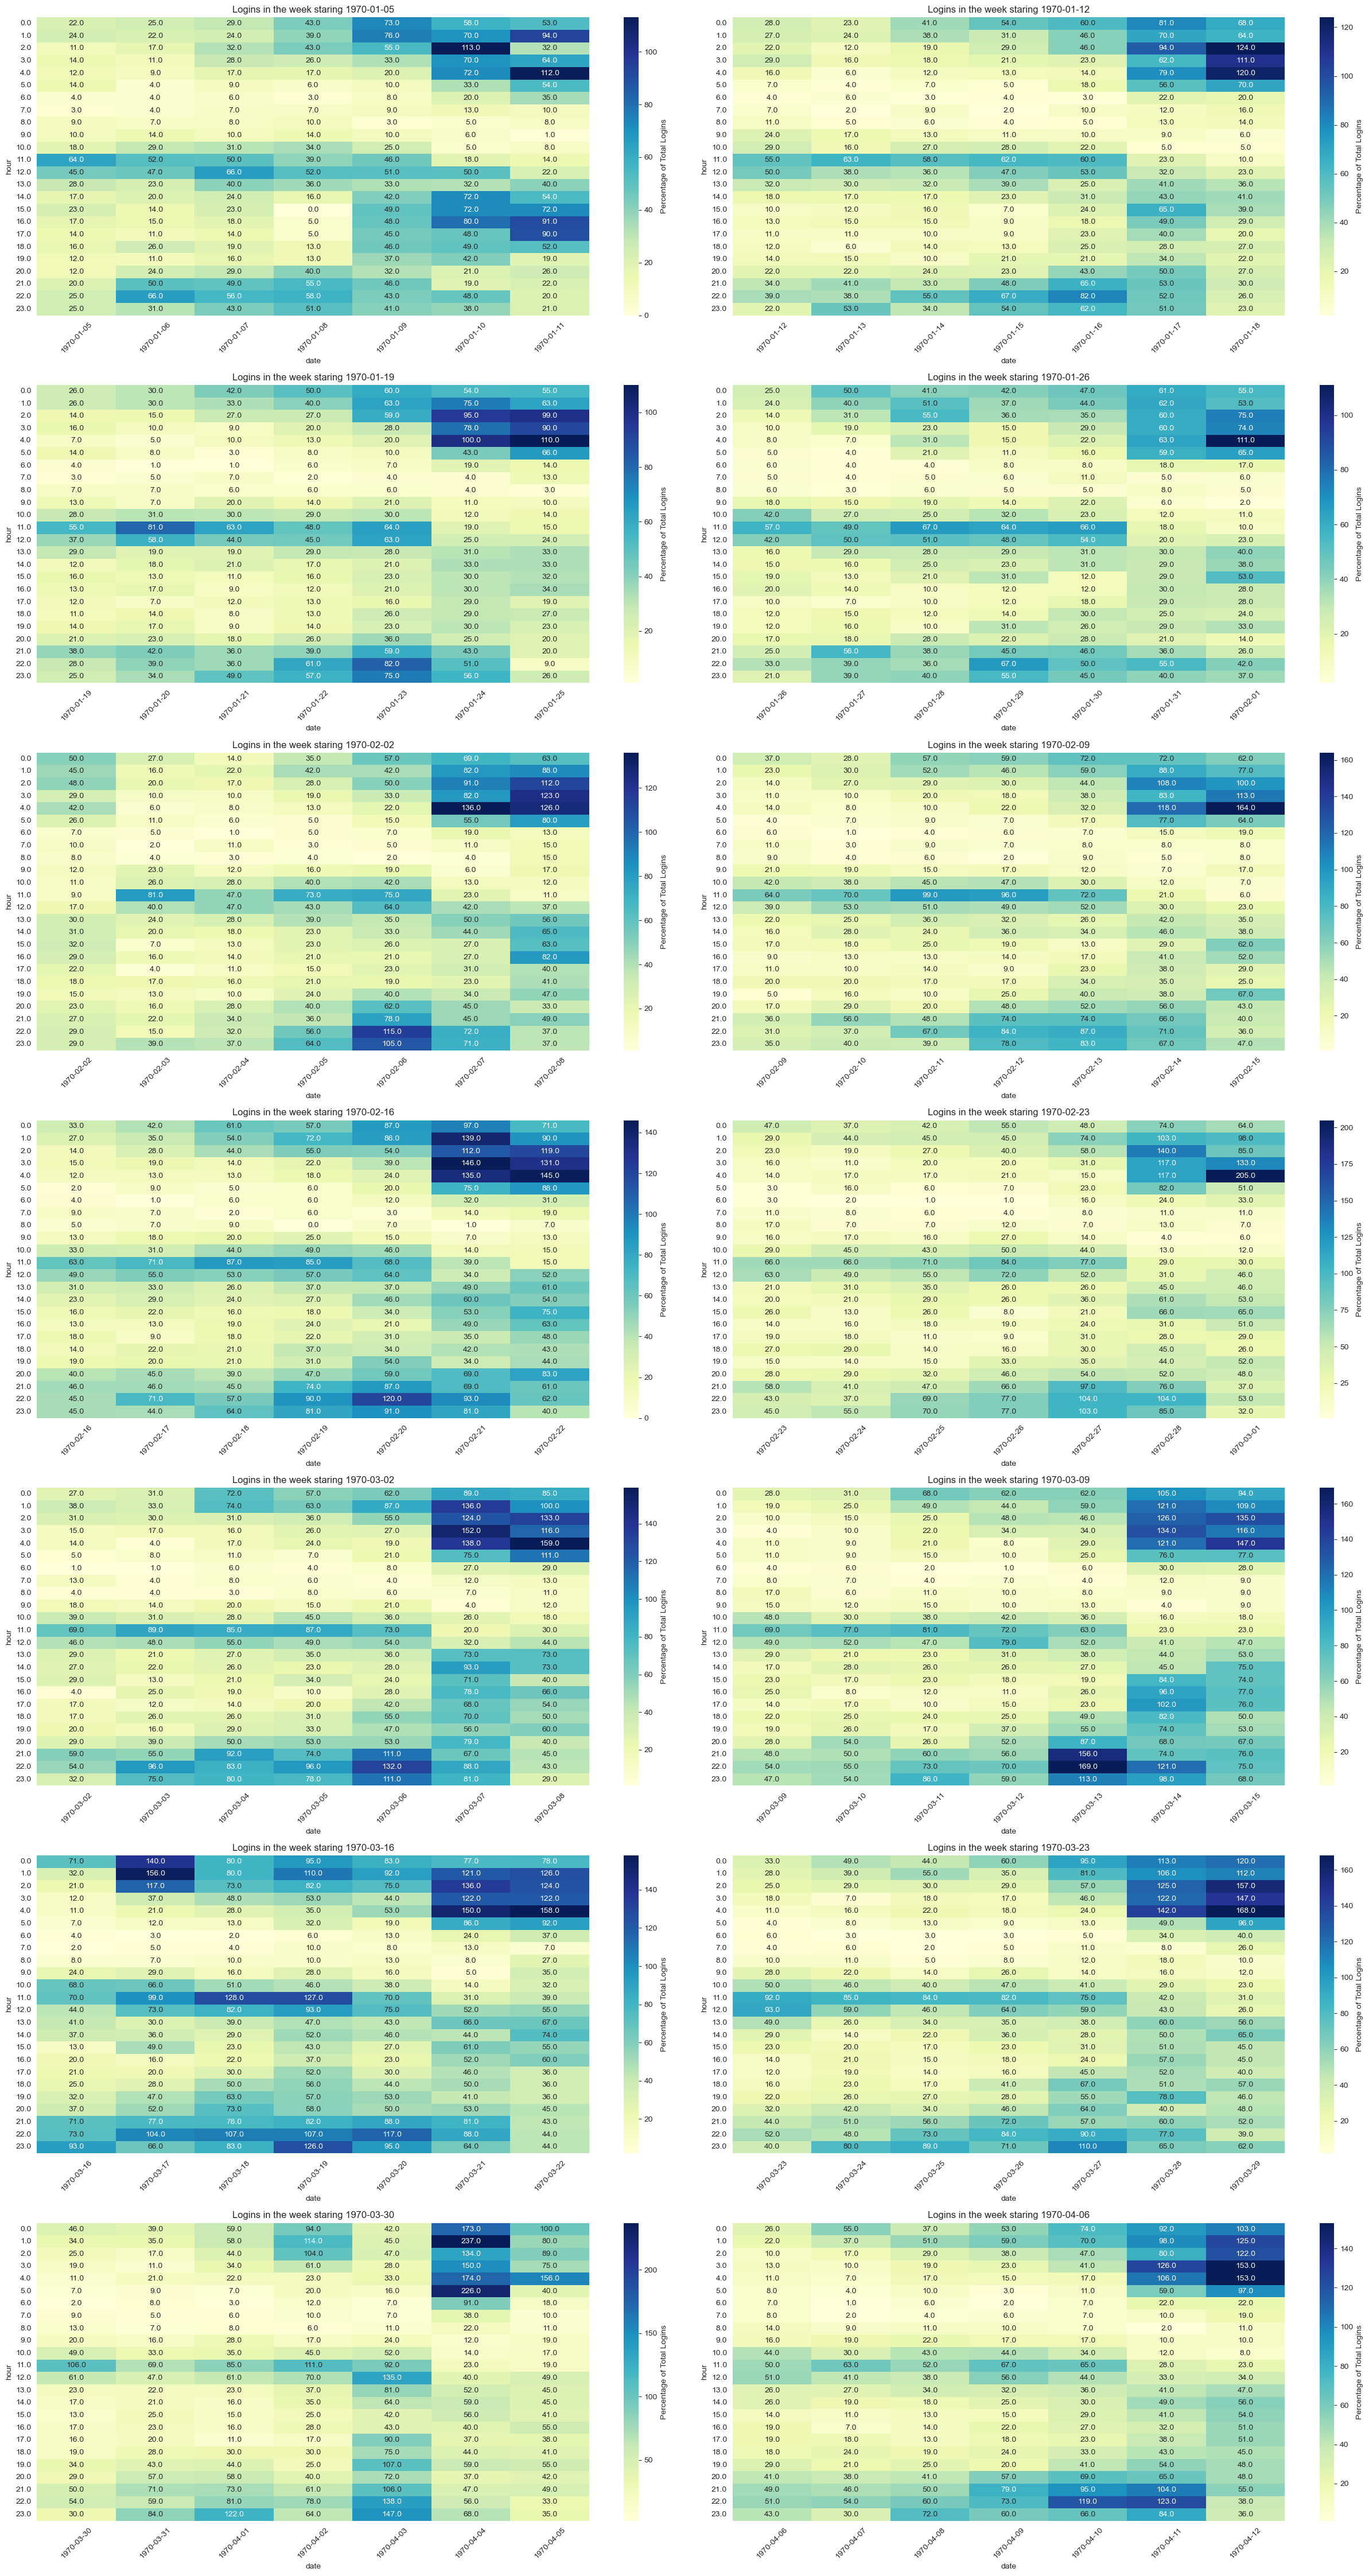

In [15]:

# Define a start date and end date
start_date = pd.to_datetime('1970-01-05')
end_date = pd.to_datetime('1970-04-12')

# Define the number of rows and columns in the grid
num_rows = 7
num_columns = 2

# Calculate the number of weeks to display
num_weeks = (end_date - start_date).days // 7 + 1  # Add 1 to include the start_date

# Create a grid of subplots
figure, axis = plt.subplots(num_rows, num_columns, figsize=(25, 45))


# Initialize a variable to keep track of the current row and column
row = 0
col = 0

# Iterate through the date range and create subplots
while start_date <= end_date:
    # Check if we need to move to the next row
    if col >= num_columns:
        col = 0
        row += 1

    # Create a subplot for the current week
    ax = axis[row, col]

    # Call the create_weekly_heatmap function for the current week
    create_weekly_heatmap(start_date, ax=ax)

    # Set the title for the subplot (customize as needed)
    date_string = start_date.strftime("%Y-%m-%d")
    ax.set_title(f"Logins in the week staring {date_string}")

    # Move the start date forward by one week
    start_date += pd.DateOffset(weeks=1)

    # Increment the column
    col += 1

# Ensure tight layout to avoid overlapping labels
plt.tight_layout()

# Show the subplots
plt.show()



<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Statistical analysis</h3>
</div>

TBD - I'd still really like to do something more 'statistical' here, but not if I'm just feeding the model exactly what I want to see.   At that point, a visual chart is just as good or better for most audiences.   
I discussed with my mentor, and came to the conclusion that any kind of chi-squared or t-test does not really make sense here.

